# Add PATH to puhti

In [1]:
!export PYTHONUSERBASE=/projappl/project_2012638/

In [2]:
import sys
!{sys.executable} -m pip install --user pymannkendall -q
!{sys.executable} -m pip install --user tensorflow -q
!{sys.executable} -m pip install --user pyod -q

# Execute

In [4]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import functions as f 

Select the file for checking 

In [5]:
PATH = 'realKnownCause/rogue_agent_key_hold.csv'
ERRORPATH = 'labels/combined_windows.json'

In [6]:
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

In [7]:
# Convert error windows to datetime
error_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in df_error]

# Raw data
## Visualise data

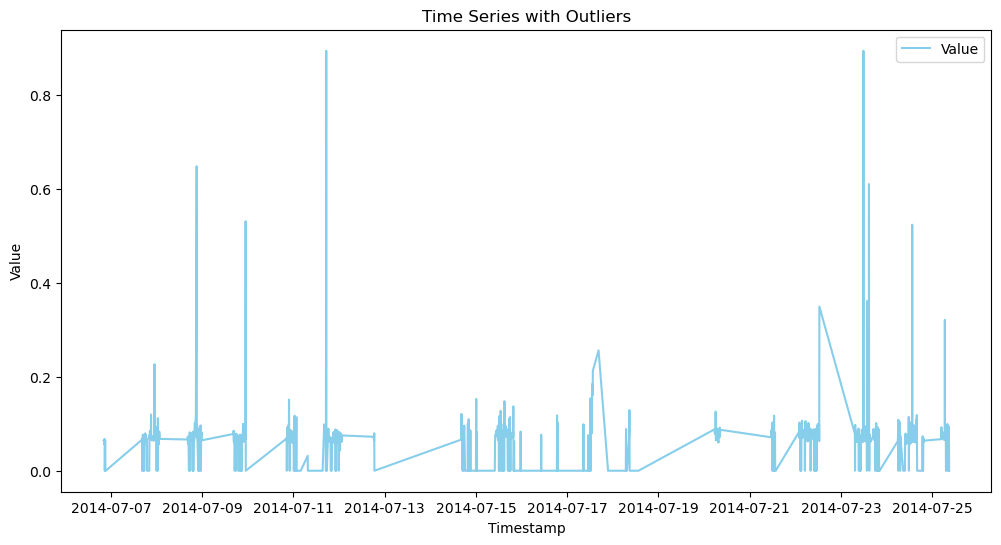

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Mark outliers
def is_outlier(timestamp, error_windows):
    for start, end in error_windows:
        if start <= timestamp <= end:
            return 1
    return 0

df['outlier'] = df['timestamp'].apply(lambda x: is_outlier(x, error_windows))


## Check percentage of the outliers against the dataset

In [ ]:
# Count the occurrences of each outlier value
counts = df['outlier'].value_counts()

# Calculate the ratio
ratio = counts.get(1, 0) / counts.get(0, 1)  # Use default 0 for missing values
print("Ratio of outliers to non-outliers:", ratio)

## Visualise data and outliers

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.scatter(df['timestamp'][df['outlier'] == 1], df['value'][df['outlier'] == 1], color='red', label='Outliers')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


## Distribution of values

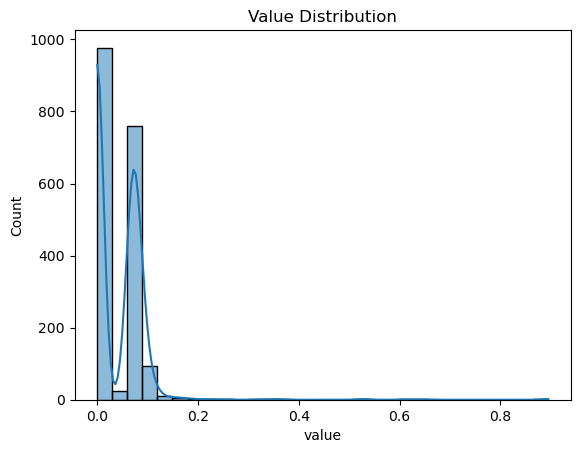

In [8]:
import seaborn as sns

# Plot value distribution
sns.histplot(df['value'], bins=30, kde=True)
plt.title('Value Distribution')
plt.show()


Pandas also provide a function to define the skewness of data. Refer to define_skewness in function.py

In [17]:
df.value.skew()

5.9547484049367885

With skew value is a positive number, this indicates the distribution is right-skewed, or the tail of the distribution is more pronounced on the right.

## Time gaps

timestamp
0 days 00:05:00    1790
0 days 00:10:00      47
0 days 00:20:00       8
0 days 00:35:00       6
0 days 00:30:00       2
0 days 00:15:00       2
0 days 00:25:00       2
0 days 14:40:00       1
0 days 00:40:00       1
0 days 19:00:00       1
0 days 16:30:00       1
0 days 21:10:00       1
0 days 03:40:00       1
0 days 00:50:00       1
0 days 16:40:00       1
1 days 21:35:00       1
0 days 03:00:00       1
0 days 05:00:00       1
0 days 06:00:00       1
0 days 03:10:00       1
0 days 01:10:00       1
0 days 00:55:00       1
1 days 16:05:00       1
1 days 02:45:00       1
0 days 12:20:00       1
0 days 18:40:00       1
0 days 01:15:00       1
0 days 09:35:00       1
0 days 01:25:00       1
0 days 02:30:00       1
0 days 08:40:00       1
Name: count, dtype: int64


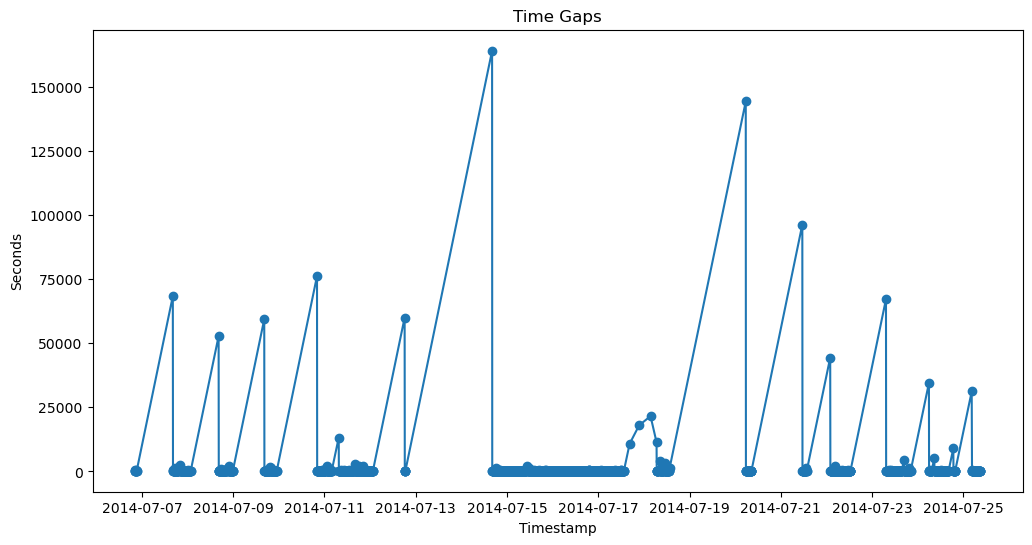

In [9]:
# Calculate time differences between consecutive timestamps
time_diff = df['timestamp'].diff()
print(time_diff.value_counts())

# Visualize time gaps
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], time_diff.dt.total_seconds(), marker='o')
plt.title('Time Gaps')
plt.ylabel('Seconds')
plt.xlabel('Timestamp')
plt.show()


Timegaps are not equal.

There is also a day gap (-1 day). This indicates the dataset is not sorted properly. 

Furthermore, below there are some time-mark that contains duplicates:

In [108]:
# Identify duplicates
duplicates = df.duplicated('timestamp', keep=False)

# Print duplicates
print('Duplicates are:')
print(df[duplicates])

Duplicates are:
                timestamp      value  outlier
10137 2014-01-07 02:00:00  94.423406        0
10138 2014-01-07 02:05:00  94.698730        0
10139 2014-01-07 02:10:00  95.332824        0
10140 2014-01-07 02:15:00  95.079199        0
10141 2014-01-07 02:20:00  94.881208        0
10142 2014-01-07 02:25:00  94.563961        0
10143 2014-01-07 02:30:00  93.430922        0
10144 2014-01-07 02:35:00  93.729663        0
10145 2014-01-07 02:40:00  93.192987        0
10146 2014-01-07 02:45:00  93.967871        0
10147 2014-01-07 02:50:00  93.397374        0
10148 2014-01-07 02:55:00  92.855999        0
10149 2014-01-07 02:00:00  94.139723        0
10150 2014-01-07 02:05:00  94.111970        0
10151 2014-01-07 02:10:00  94.638723        0
10152 2014-01-07 02:15:00  93.270907        0
10153 2014-01-07 02:20:00  93.890249        0
10154 2014-01-07 02:25:00  93.396627        0
10155 2014-01-07 02:30:00  94.199300        0
10156 2014-01-07 02:35:00  94.125420        0
10157 2014-01-07 0

To avoid this problem, propose function process_time_series. Redo the whole process.

In this new process, 
* data must be sorted first in an ascending order, meaning the timestamp must increase over time.
* define the most frequent interval in the dataset
* the dataset will be grouped based on the found interval

Refer to process_time_series function in functions.py

Furthermore, if there exists NA value after groupping, using linear interpolation to fill the NaN value. Linear interpolation is applied based on the assumption that data should change overtime. 
# New process - sort and group data, linear interpolation

In [7]:
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
# Apply process_time_series, resampled dataset and also apply linear interpolation 



time_diff, df = f.process_time_series(df, grouping=True)

with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

# Convert error windows to datetime
error_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in df_error]

# Mark outliers
def is_outlier(timestamp, error_windows):
    for start, end in error_windows:
        if start <= timestamp <= end:
            return 1
    return 0

df['outlier'] = df['timestamp'].apply(lambda x: is_outlier(x, error_windows))


Examine the dataset

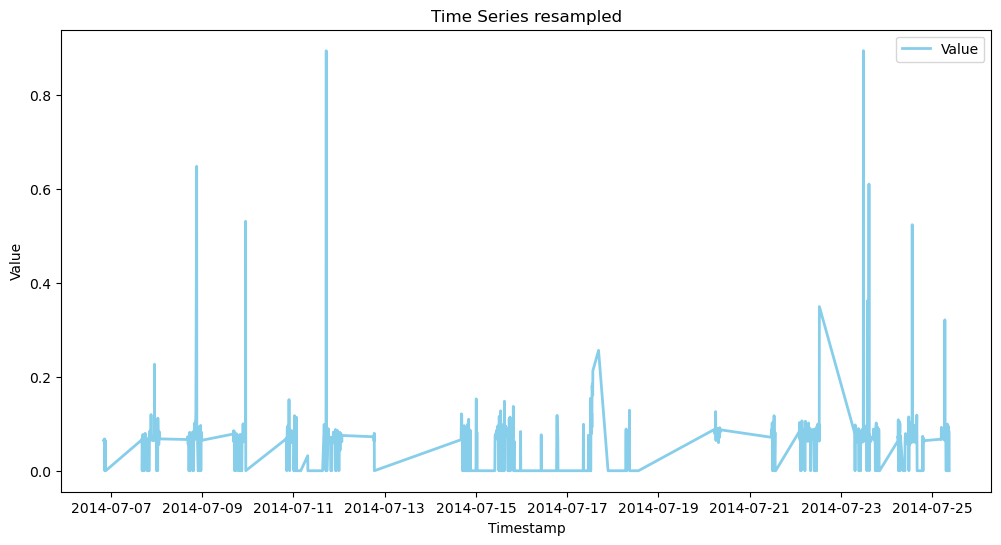

In [8]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue', linewidth=2)
plt.title('Time Series resampled')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

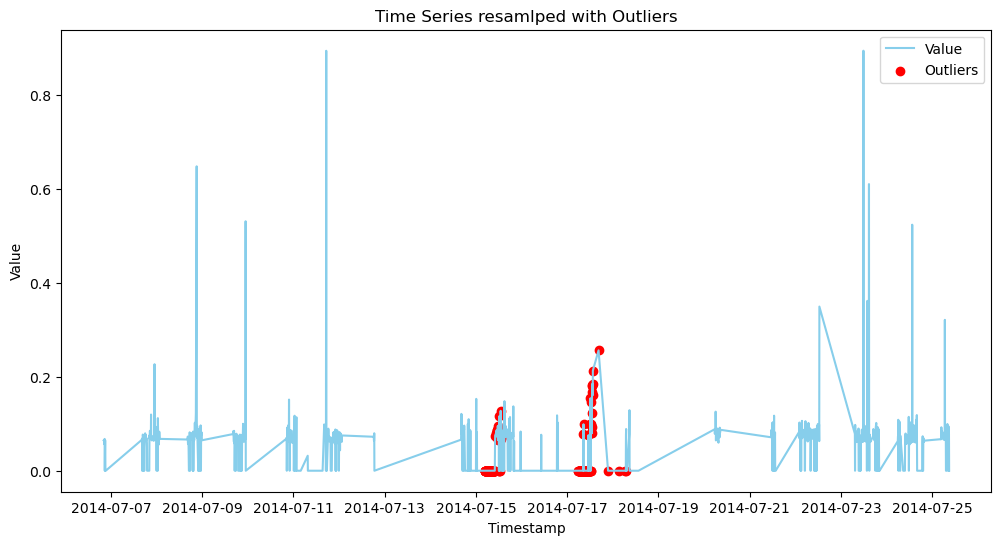

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.scatter(df['timestamp'][df['outlier'] == 1], df['value'][df['outlier'] == 1], color='red', label='Outliers')
plt.title('Time Series resamlped with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


## Apply smoothing 
* Moving Average
* Exponential smoothing

In [10]:
def smoothing(df, selection):
    from sklearn.metrics import mean_squared_error
    import numpy as np 
    
    if selection == 'ma': #moving average
        # Function to calculate rolling average and return MSE
        def calculate_mse(window_size, data):
            if window_size > len(data):
                return np.inf  # Return infinity if window size is larger than the data length
            smoothed_values = data.rolling(window=window_size).mean()
            mse = mean_squared_error(data[window_size-1:], smoothed_values[window_size-1:])
            return mse
        
        # Grid search for optimal window size
        window_sizes = range(2, len(df) + 1)
        mse_values = []
        
        for window_size in window_sizes:
            mse = calculate_mse(window_size, df['value'])
            mse_values.append(mse)
        
        # Find the window size with the minimum MSE
        optimal_window_size = window_sizes[np.argmin(mse_values)]

        df['smoothed'] = df['value'].rolling(window=optimal_window_size).mean()
    else: #ewm
        def calculate_mse(alpha, data):
            smoothed_values = data.ewm(alpha=alpha, adjust=False).mean()
            mse = mean_squared_error(data, smoothed_values)
            return mse
        
        # Grid search for optimal alpha
        alpha_values = np.arange(0.01, 0.95, 0.01)
        mse_values = []

        for alpha in alpha_values:
            mse = calculate_mse(alpha, df['value'])
            mse_values.append(mse)
        
        # Find the alpha with the minimum MSE
        optimal_alpha = alpha_values[np.argmin(mse_values)]
        df['smoothed'] = df['value'].ewm(alpha=optimal_alpha, adjust=False).mean()
    return df 

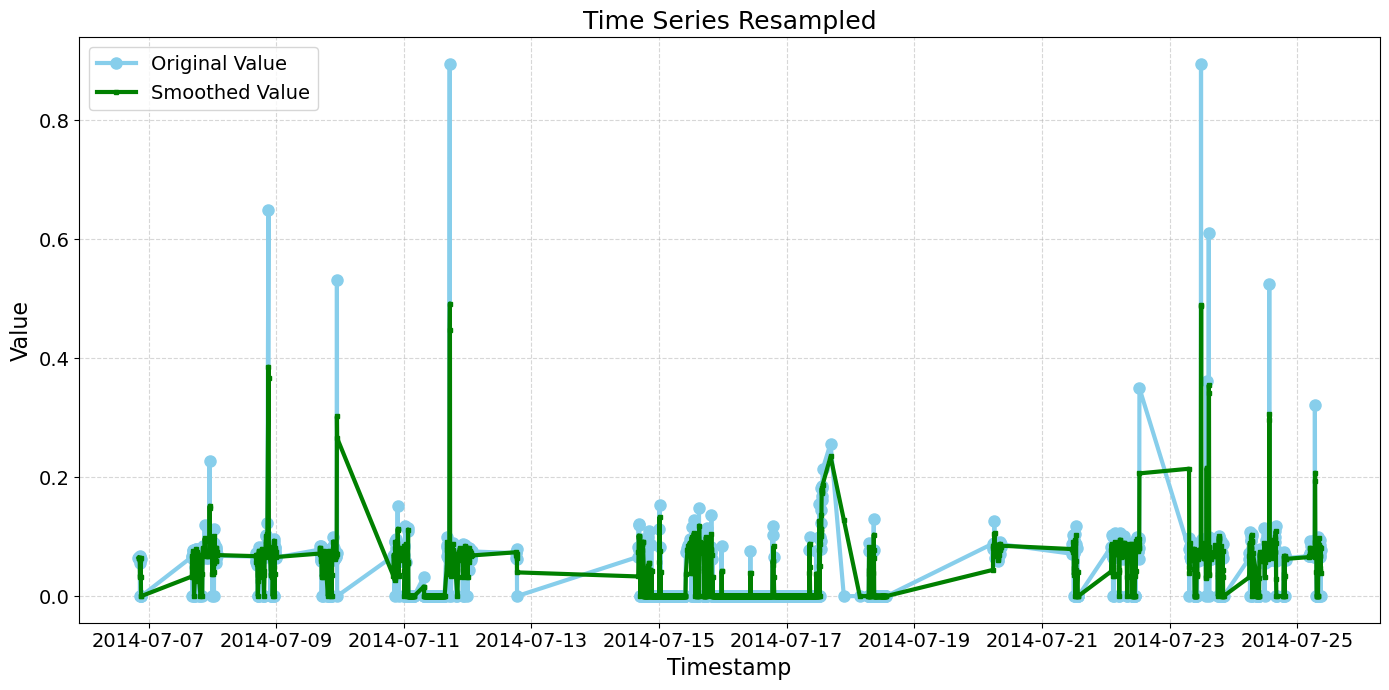

In [11]:
df = smoothing(df, 'ma')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['value'], label='Original Value', color='skyblue', linewidth=3, linestyle='-', marker='o', markersize=8)
plt.plot(df['timestamp'], df['smoothed'], label='Smoothed Value', color='green', linewidth=3, linestyle='-', marker='s', markersize=3)
plt.title('Time Series Resampled', fontsize=18)
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

## Check the ratio of outliers

In [12]:
# Count the occurrences of each outlier value
counts = df['outlier'].value_counts()

# Calculate the ratio
ratio = counts.get(1, 0) / counts.get(0, 1)  # Use default 0 for missing values
print("Ratio of outliers to non-outliers:", ratio)

Ratio of outliers to non-outliers: 0.11229314420803782


## Visualise data and outliers

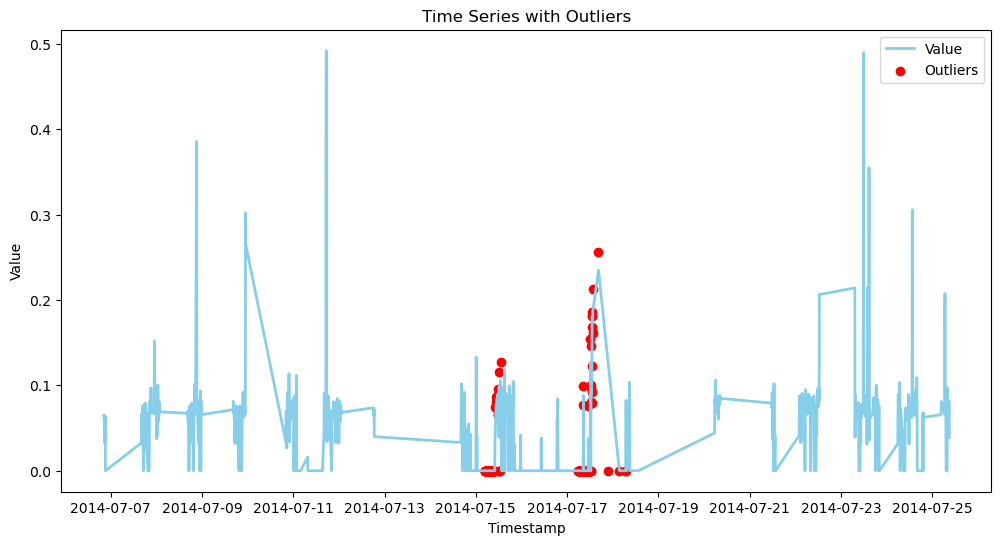

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['smoothed'], label='Value', color='skyblue', linewidth=2)
plt.scatter(df['timestamp'][df['outlier'] == 1], df['value'][df['outlier'] == 1], color='red', label='Outliers')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

Plot the distribution of the values

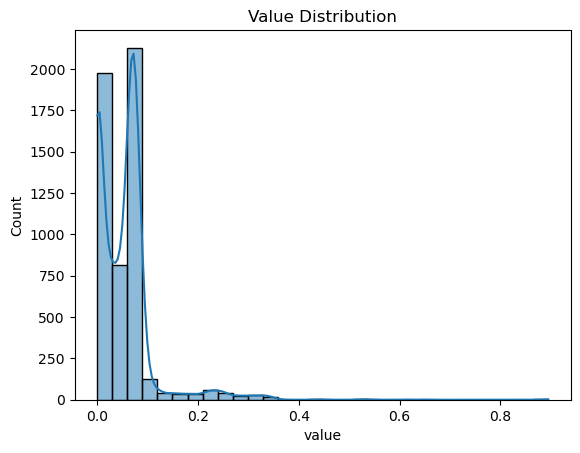

In [14]:
import seaborn as sns

# Plot value distribution
sns.histplot(df['value'], bins=30, kde=True)
plt.title('Value Distribution')
plt.show()

Similarly, pandas.skew() can be applied here:

In [14]:
print('Value skewness: ', df.value.skew())

Value skewness:  5.9547484049367885


With the given time_diff, the period for:
* if time_diff <= 15 min: 1 hour, daily
* time_diff between 15 - 60min: 3 hours, daily

In [15]:
periods = f.period(time_diff)
periods

{'first': 12, 'second': 288}

# Perform ARIMA 

In [16]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

df1 = df.copy().dropna()

auto_model = auto_arima(df1.smoothed, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())
print('Best ARIMA order is: ', auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8710.185, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7645.799, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7647.582, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7647.799, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8714.337, Time=1.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-8692.325, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-8671.982, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.70 sec


In [17]:
# Fit ARIMA model to the residuals
arima_model = ARIMA(df1.smoothed, order=auto_model.order)
arima_result = arima_model.fit()

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


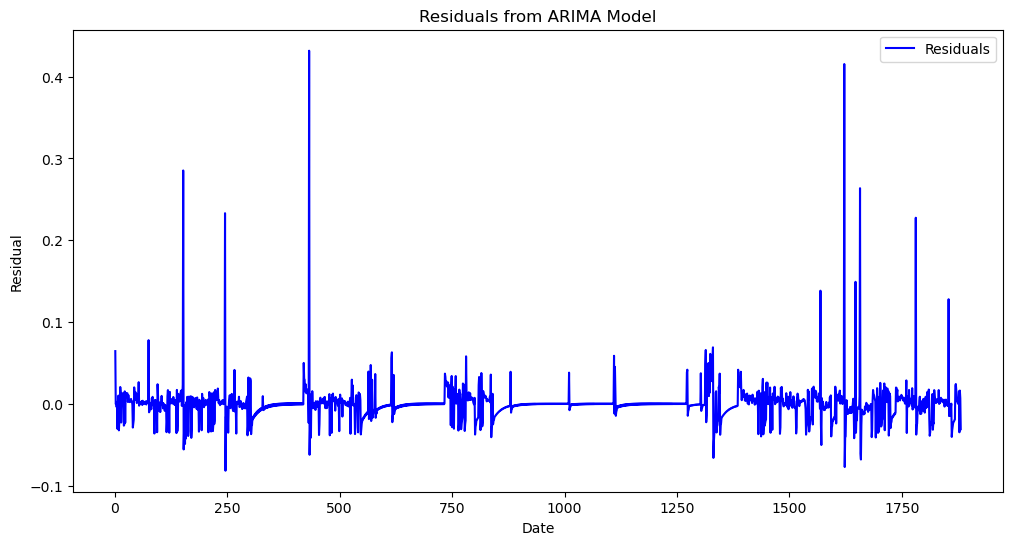

In [18]:
# Calculate residuals
residuals = df1['smoothed'] - arima_result.fittedvalues

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

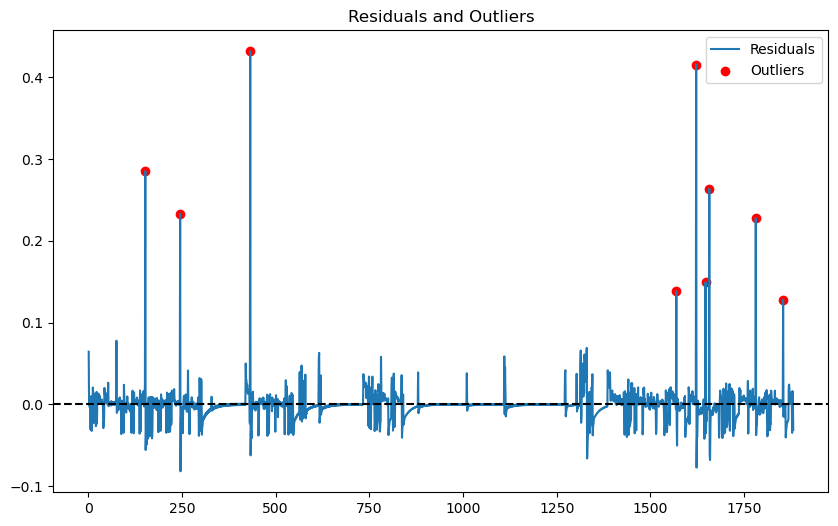

In [22]:
import numpy as np
# Define a threshold for outliers (e.g., 2 standard deviations from the mean)
#threshold = 3 * np.std(residuals)

# Identify outliers
#outliers = residuals[np.abs(residuals) > threshold]


# Calculate IQR for threshold
Q1 = np.percentile(residuals, 5)
Q3 = np.percentile(residuals, 95)
IQR = Q3 - Q1

# Define thresholds using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]

# Plot residuals and outliers
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals and Outliers')
plt.legend()
plt.show()


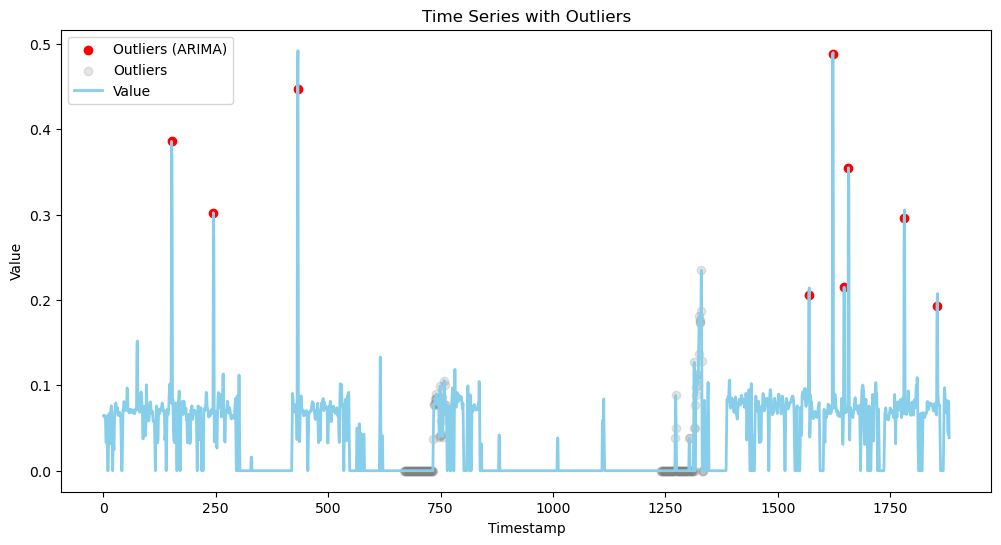

In [25]:
# Mark outliers in the DataFrame
df1['outlier_arima'] = 0
df1.loc[outliers.index, 'outlier_arima'] = 1

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(df1.index[df1['outlier_arima'] == 1], df1['smoothed'][df1['outlier_arima'] == 1], color='red', label='Outliers (ARIMA)', zorder=1)
plt.scatter(df1.index[df1['outlier'] == 1], df1['smoothed'][df1['outlier'] == 1], color='gray', label='Outliers', zorder=2, alpha=0.2)
plt.plot(df1.index, df1['smoothed'], label='Value', color='skyblue', linewidth=2)
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

## TimeGAN

In [20]:
df1

,timestamp,value,outlier,smoothed
1,2014-07-06 20:15:00,0.064295,0,0.064415
2,2014-07-06 20:20:00,0.063880,0,0.064088
3,2014-07-06 20:25:00,0.065692,0,0.064786
4,2014-07-06 20:35:00,0.056301,0,0.060997
5,2014-07-06 20:40:00,0.067751,0,0.062026
...,...,...,...,...
1877,2014-07-25 08:35:00,0.094647,0,0.082170
1878,2014-07-25 08:40:00,0.000000,0,0.047323
1879,2014-07-25 08:45:00,0.085243,0,0.042622
1880,2014-07-25 08:50:00,0.077485,0,0.081364


In [26]:
from timegan_v2_18 import timegan 
df2 = df1[['timestamp', 'smoothed']]

# Convert to NumPy array (reshaped for TimeGAN)
data = np.array(df2.smoothed).reshape(-1, 1)  # Shape (100, 1)
seq_length = 3  # Sequence length for TimeGAN

# Convert to sequences (past 10 values per sample)
time_series = []

for i in range(len(data) - seq_length):
    time_series.append(data[i:i + seq_length])
ori_data = np.array(time_series)

parameters = {
    "hidden_dim": 10,   # Hidden units in RNN
    "num_layer": 2,     # Number of layers
    "iterations": 1000, # Training iterations
    "batch_size": 16,   # Mini-batch size
    "module": "gru"     # RNN type: 'gru', 'lstm', or 'lstmLN'
}

generated_data = timegan(ori_data, parameters)
print(f"Generated Data Shape: {np.array(generated_data).shape}")

W0000 00:00:1738239360.029441 1299637 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 0: Training step completed
Generated Data Shape: (1878, 3, 1)


In [27]:
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Epoch 0, D_loss: 1.3797
Epoch 500, D_loss: 0.9987
Epoch 1000, D_loss: 0.2953
Epoch 1500, D_loss: 0.1498
Epoch 0, D_loss: 1.3267
Epoch 500, D_loss: 0.9536
Epoch 1000, D_loss: 0.2751
Epoch 1500, D_loss: 0.1597
Epoch 0, D_loss: 1.4585
Epoch 500, D_loss: 1.3809
Epoch 1000, D_loss: 1.2634
Epoch 1500, D_loss: 0.3511
Epoch 0, D_loss: 1.5283
Epoch 500, D_loss: 1.3848
Epoch 1000, D_loss: 1.3005
Epoch 1500, D_loss: 0.4369
Epoch 0, D_loss: 1.4117
Epoch 500, D_loss: 1.3810
Epoch 1000, D_loss: 1.3022
Epoch 1500, D_loss: 1.1256
Discriminative score: 0.496


In [28]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2025-01-30 14:26:33.008140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:26:33.455298: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:26:34.342664: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:26:36.229692: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:26:39.820292: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:26:46.893662: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-30 14:27:01.596331: I tensorflow/core/framework/local_rendezvous.cc:405] L

Predictive score: 0.2507


In [53]:
# Convert generated_data to NumPy array
generated_dataa = np.array(generated_data)

# Compute Reconstruction Error (Mean Absolute Error)
reconstruction_error = np.mean(np.abs(ori_data - generated_dataa), axis=(1, 2))

# Print error statistics
print(f"Reconstruction Error Stats: Min={np.min(reconstruction_error)}, Max={np.max(reconstruction_error)}, Mean={np.mean(reconstruction_error)}")

# Set anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 98)

# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

print(f"Outlier Indices: {outliers}")

Reconstruction Error Stats: Min=0.07124646913501993, Max=0.26965587337811786, Mean=0.23146398226463646
Outlier Indices: [ 314  320  336  377  399  554  583  594  595  632  634  651  664  672
  699  848  859  864  868  914  924  933  936  941  961  980  994  995
 1042 1057 1097 1143 1191 1231 1250 1354 1366 1545]


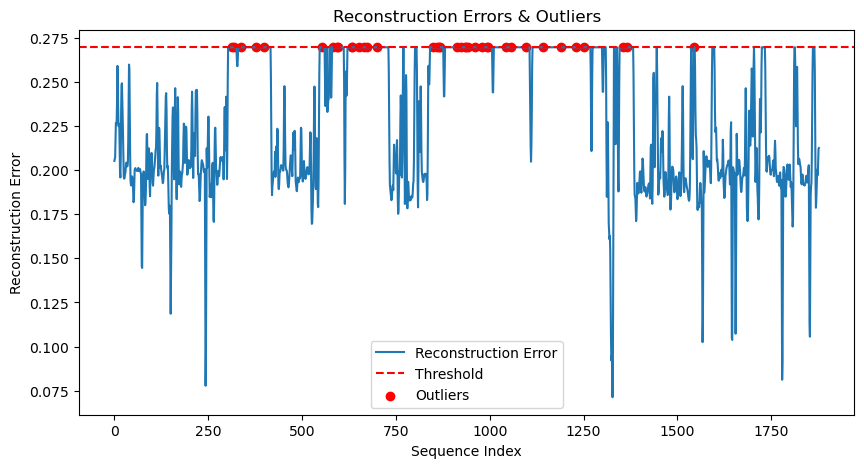

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.scatter(outliers, reconstruction_error[outliers], color="red", label="Outliers")
plt.title("Reconstruction Errors & Outliers")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


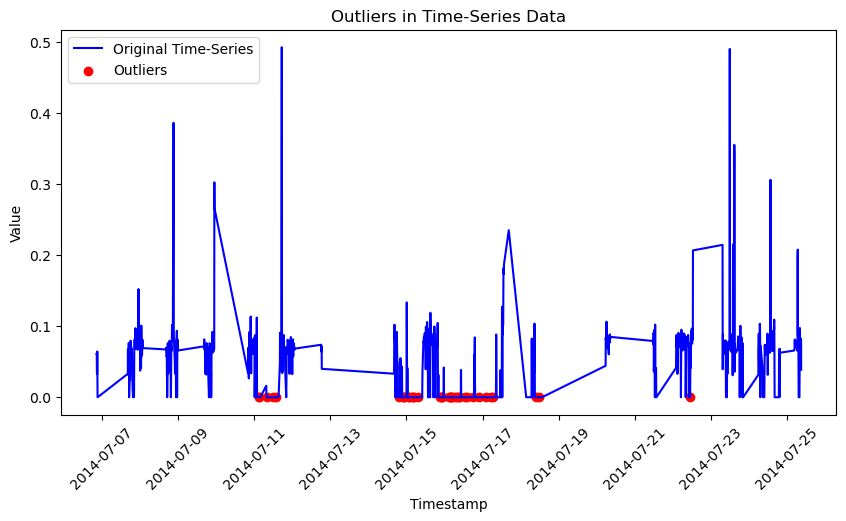

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(df2.timestamp[seq_length:], df2.smoothed[seq_length:], label="Original Time-Series", color="blue")
plt.scatter(
    [df2.timestamp[i + seq_length - 1] for i in outliers],  # Last timestamp of each outlier sequence
    [df2.smoothed[i + seq_length - 1] for i in outliers], 
    color="red", 
    label="Outliers"
)
plt.title("Outliers in Time-Series Data")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()


# ECOD

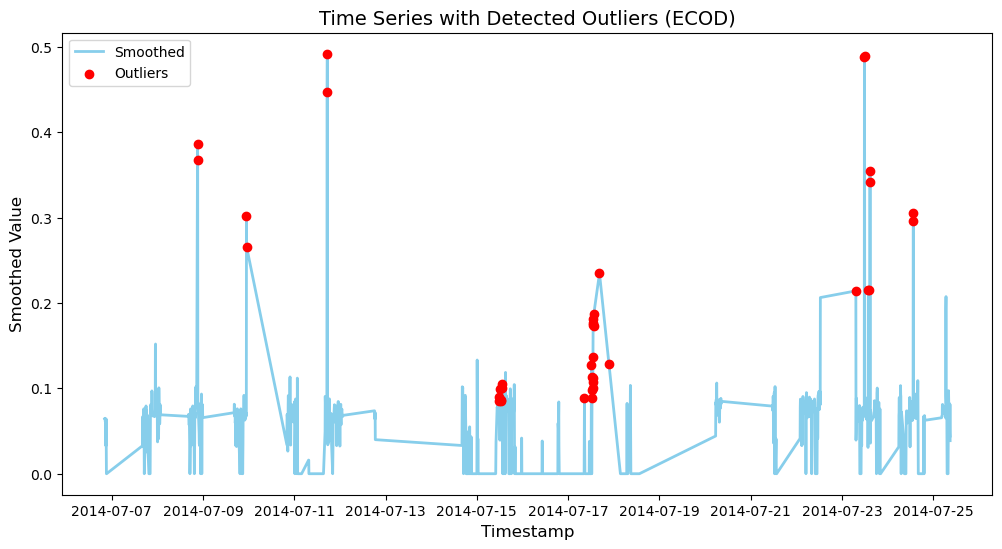

In [52]:
from pyod.models.ecod import ECOD
from sklearn.model_selection import train_test_split


X_with_outliers = np.column_stack([df1['smoothed'], df1['outlier']])

# Step 1: Initialize the ECOD model
ecod = ECOD()

# Step 2: Fit the ECOD model on the entire dataset
ecod.fit(X_with_outliers)

# Step 3: Get outlier scores for the dataset
outlier_scores = ecod.decision_function(X_with_outliers)

# Step 5: Identify outliers based on a threshold (e.g., top 5% outliers)
threshold = np.percentile(outlier_scores, 98)  # Top 5% as outliers
df1['predicted_outlier'] = outlier_scores > threshold  # Mark outliers in the dataframe

# Step 5: Plot the time series data
plt.figure(figsize=(12, 6))

# Plot the smoothed values
plt.plot(df1['timestamp'], df1['smoothed'], label='Smoothed', color='skyblue', linewidth=2)

# Highlight the outliers in red
plt.scatter(df1['timestamp'][df1['predicted_outlier'] == 1], df1['smoothed'][df1['predicted_outlier'] == 1],
            color='red', label='Outliers', zorder=5)

# Adding title, labels, and legend
plt.title('Time Series with Detected Outliers (ECOD)', fontsize=14)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Smoothed Value', fontsize=12)
plt.legend()

# Show the plot
plt.show()




# Draft

## Define data period of daily and monthly (count of data)

Before finding the trend, seasonality, residual of the dataset, which can be found under this library: from statsmodels.tsa.seasonal import seasonal_decompose

period per day, week, month must be found. Period is the number of events within the defined timeframe. For example, if the interval is 300seconds, 1 day is calculated as:
$$period\_1\_day = \frac{24 hours \times 60 minutes \times 60 seconds}{300 seconds}$$
The function can be found under name period_pattern in functions.py

In [11]:
periods = f.period_pattern(df, time_diff)

In [12]:
keys, values = list(periods.keys()), list(periods.values())

## Seasonal decomposition

* The trend represents the long-term movement or direction in the data. It can be upward, downward, or flat. A trend reflects the gradual increase or decrease over time and is often influenced by factors like population growth, economic shifts, or technological advances.
* Seasonality refers to repeating patterns or cycles that occur at regular intervals within a year, month, week, or even day. These patterns are often driven by external factors such as seasons, holidays, or events.
* The residual is the leftover part of the time series that cannot be explained by the trend or seasonality. It represents random variations, noise, or outliers in the data. This component captures the unpredictable, irregular fluctuations that do not follow a systematic pattern.

Before that, it is good to know whether the data is additive or multiplicative. These terms describe the relationship between the components: trend, seasonality, and residual. At a given time t, additive is defined as:
$$ Y(t) = T(t) + S(t) + R(t) $$
Key Characteristics:

* Trend and seasonal variations are independent of the level of the time series.
* The size of the seasonal variation is constant over time.
* Example: Daily temperatures that fluctuate around a constant trend with similar highs and lows each year.
Multiplicative is defined as:
$$ Y(t) = T(t) * S(t) * R(t) $$
Alternatively, taking logs in 2 sides:
$$ logY(t) = logT(t) + logS(t) + logR(t) $$
Key Characteristics:

* Seasonal variations depend on the level of the time series.
* The size of the seasonal variation increases or decreases proportionally with the trend.
* Example: Retail sales where seasonal spikes (e.g., holidays) grow as the overall trend increases over time.

To automate this process:
* Check variance and rolling correlation.
* Apply a log transformation and assess variance stability.
* Perform decomposition and check seasonal proportionality.
* Compare additive and multiplicative models using error metrics.

Furthermore: 
* Correlation between 0.5 - 0.7 suggests moderately correlated (https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm#:~:text=Correlation%20coefficients%20whose%20magnitude%20are%20between%200.5%20and%200.7%20indicate,can%20be%20considered%20moderately%20correlated.)
* To determine the threshold of variance reduction, either applying KNN with Elbow to find the number of cluster where adding more cluster does not add more knowlege to the prediction (elbow) or Sillouette method in which a higher silhouette score indicates that clusters are well-defined and separated.
* Compare the Exponential Smoothing using RSME, select one with lower score.

Refer to function Define multiplicative or additive functions in functions.py

In [13]:
periods

{3: 900, 6: 1800, 9: 2700, 288: 86400}

In [14]:
add_or_mul = f.add_or_mul(df.copy(), periods, 'value')
add_or_mul

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


['Multiplicative', 'Additive', 'Additive', 'Multiplicative']

Plugging the additive or multiplicative to the seasonal_decompose.

Adding try and except to escape the case if there is not enough data

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

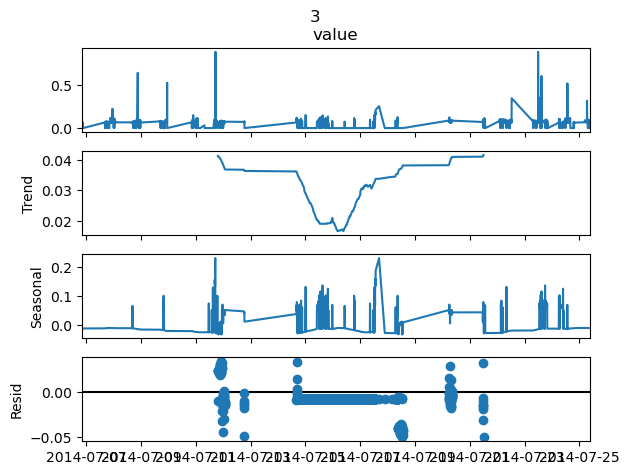

In [17]:
for i in range(len(periods)):
    try:
        decomposition = seasonal_decompose(df.set_index('timestamp')['value'], model=add_or_mul[i],
                                       period=values[i])  # Adjust period
    except:
        continue
    fig = decomposition.plot()
    fig.suptitle(keys[i])
    # Adjust spacing to avoid overlap
    fig.subplots_adjust(top=0.9)  # Adjust the top margin to make space for the title

    plt.show()


Only 1 period is displayed. The rest do not have enough data.

## Statistical measure to determine if there is a significant trend, seasonal pattern, or residual component in time series data

The Shapiro-Wilk test checks if the residuals are normally distributed. In time series analysis, normally distributed residuals suggest that the model has effectively captured the systematic patterns (trend and seasonality) (https://otexts.com/fpp2/residuals.html)

Mann-Kendall test to check the trend  (https://medium.com/@snp.kriss/statistical-test-methods-to-detect-trends-in-time-series-data-b361a0ec530b)

Krushkal-Wallis test for seasonality

The example will be done with model multiplicative (first result of add_or_mul above), daily period (first result of periods)

In [24]:
decomposition = seasonal_decompose(df.set_index('timestamp')['value'], model=add_or_mul[0], period=values[0])

# Access the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposed_df = pd.DataFrame({
    'timestamp': trend.index,  # Use the index of the trend, which matches the original timestamp
    'value': df['value'].values,
    'trend': trend.values,
    'seasonal': seasonal.values,
    'residual': residual.values
}).reset_index(drop=True)

In [25]:
decomposed_df.to_csv('decomposed.csv')

In [22]:
import numpy as np
from scipy.stats import shapiro

# Calculate variances
trend_variance = np.var(decomposed_df['trend'].dropna())
seasonal_variance = np.var(decomposed_df['seasonal'].dropna())
residual_variance = np.var(decomposed_df['residual'].dropna())

print(f"Trend Variance: {trend_variance}")
print(f"Seasonal Variance: {seasonal_variance}")
print(f"Residual Variance: {residual_variance}")

# Normality test for residuals
stat, p_value = shapiro(decomposed_df['residual'].dropna())
print(f"Shapiro-Wilk Test for Residuals: p-value = {p_value}")

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

Trend Variance: 5.61556711567046e-05
Seasonal Variance: 0.0012360829390834695
Residual Variance: 9.143565582216172e-05
Shapiro-Wilk Test for Residuals: p-value = 1.5764665272295577e-47
Residuals are not normally distributed.


In [23]:
import pymannkendall as mk

# Assuming 'value' is your time series data
result = mk.original_test(decomposed_df['value'])

print(f"Trend: {result.trend}")
print(f"Slope: {result.slope}")
print(f"P-value: {result.p}")

Trend: increasing
Slope: 0.0
P-value: 0.012629555083700117


In [30]:
from scipy.stats import kruskal

groups = [group.dropna() for _, group in seasonal.groupby(seasonal.index)]
# Perform Kruskal-Wallis test
stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis Test: p-value = {p_value}")

if p_value < 0.05:
    print("Seasonal pattern detected.")
else:
    print("No seasonal pattern detected.")

Kruskal-Wallis Test: p-value = 0.4956637733878398
No seasonal pattern detected.


These statistics can be found in analyze_time_series in functions.py

# Initial pipeline

<img src="images/initial_process.png" alt="image info" />

In [148]:
import functions as f

In [149]:
PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_windows.json'

In [150]:
file_names = f.get_all_files(PATH)
all_csv = [pd.read_csv(csv) for csv in file_names]
all_error = [f.retrieve_error_window(filename) for filename in file_names]

AttributeError: module 'functions' has no attribute 'retrieve_error_window'